# Interleaved Binomial kT-Points for Water-Selective Imaging at 7T

Demo code for the paper "Interleaved Binomial kT-Points for Water-Selective Imaging at 7T" by Daniel Löwen, Eberhard D. Pracht, Rüdiger Stirnberg, Patrick Liebig and Tony Stöcker.

Dependencies:
* python 3.x
* numpy
* sigpy.RF
* scipy
* matplotlib
* ipywidgets
* mpl_toolkits
* copy
* bipolar (https://github.com/endolith/bipolar-colormap.git)


# Imports

In [1]:
%matplotlib widget

import numpy as np
import sigpy.mri.rf as rf

import interleaved
from load_data import loadmat, read_ini, write_ini
import show_results

gamma = 42577 # Hz/mT

# Load data

Load system and pulse information from 'SysDataUser.mat', 'AdjDataUserSim.mat' and the ini-file.

|Variable|Description|Unit|
|:---|:---|:---|
|Sys['bmain']     | main magnetic field strength     |T      |
|Sys['gmax']      | maximum gradient strength        |mT/m   |
|Sys['smax']      | maximum slew rate                |mT/m/ms|
|Adj['coils']     | number of independent channels   |-      |
|Adj['S']         | sensitivity-profiles (or B1-maps)|µT/V   |
|S                | rearanged sensitivity-profiles   | 
|Adj['B0']        | B0map-image holding the main magnetic field deviations from the main magnetic field strength Bmain                                                |Hz     |              
|Adj['W']         | validity-mask-image              |-      |
|Adj['values_m']  | image pixel positions            |mm     |
|Adj['values_n']  | image pixel positions            |mm     |
|Adj['slices']    | slice positions                  |mm     |
|Adj['image_m']   | number of pixels in m direction  |-      |
|Adj['image_n']   | number of pixels in n direction  |-      |
|Adj['image_s']   | number of slices                 |-      |
|g                | gradient trajectory              |mT/m   |
|RF               | RF-pulse shape                   |V      |
|dt               | gradient sampling time           |s      |

In [2]:
ini_in = 'data/pTXRFPulse_7kT_50us.ini' # pTXRFPulse_(number of kT-points)_(sub-pulse duration).ini

Sys = loadmat('data/SysDataUserBrain.mat')           # measured in-vivo parameters 'SysDataUserBrain.mat' ...
Adj = loadmat('data/AdjDataUserBrain.mat')['Adj']    # ... and 'AdjDataUserBrain.mat'
g, RF, dt = read_ini(ini_in)

S = np.transpose(np.reshape(Adj['S'], (Adj['image_n'], Adj['image_m'], Adj['coils'], Adj['slices'])), (2,1,0,3))

x, z, y = np.meshgrid(Adj['values_n']/2.7, Adj['values_s']/2.7, Adj['values_m']/2.7)
spatial = np.concatenate((np.reshape(x, (Adj['image_m']*Adj['image_n']*Adj['slices'], 1)), 
                          np.reshape(y, (Adj['image_m']*Adj['image_n']*Adj['slices'], 1)), 
                          np.reshape(z, (Adj['image_m']*Adj['image_n']*Adj['slices'], 1))), axis=1)/1000 # spatial in m

# Create binomial pulse

Create an interleaved binomial kT-points pulse from a normal (previously designed) kT-points pulse. 

In [3]:
fat_freq = -980 # Fat frequency in Hz at 7T asuming shift of -3.3ppm
binomial_order = 2

g_bino, RF_bino = interleaved.calc_bino(g, RF, dt, fat_freq, Sys['gmax'], Sys['smax'], Adj['coils'], binomial_order)

# Write Pulse to ini-file

Write calculated interleaved binomial kT-points pulse to an ini-file

In [4]:
write_ini(ini_in, binomial_order, g_bino, RF_bino);

# Bloch simulations

## Water simulation

Perform bloch simulation using the normal B0-map (slice by slice) and calculate the mean flip angle over the 3D volume

In [5]:
bl_water = np.zeros((Adj['image_n']*Adj['image_m'],Adj['slices']))
mw = np.zeros(Adj['slices'])
tot_vox = 0


for slc in np.arange(Adj['slices']):
    spatial_slc = spatial[Adj['image_m']*Adj['image_n']*slc:Adj['image_m']*Adj['image_n']*(slc+1)]
    a, b, m, mz = rf.abrm_ptx(RF_bino, spatial_slc, g_bino * gamma * dt * 2 * np.pi, dt, fmap=Adj['B0'][:,:,slc], sens=S[:,:,:,slc]*Adj['W'][:,:,slc]/1000)
    vox = np.nonzero(np.reshape(np.transpose(Adj['W'][...,slc]),(4096,1)))[0].shape[0]
    mw[slc] = vox*np.mean(np.arcsin(np.abs(2 * a * np.conj(b)))[np.nonzero(np.reshape(np.transpose(Adj['W'][...,slc]),(4096,1)))])
    tot_vox += vox
    bl_water[:,slc] = np.arcsin(np.abs(2 * a * np.conj(b)))[:,0]

print('mean FA =',np.sum(mw)/tot_vox*180/np.pi)
bl_water = np.reshape(bl_water,(Adj['image_n'],Adj['image_m'],Adj['slices']),order='F')*180/np.pi

mean FA = 7.273702127149489


## Fat simulation

Perform bloch simulation using a "fat-only" B0-map (slice by slice) and calculate the mean flip angle over the 3D volume

In [6]:
bl_fat = np.zeros((Adj['image_n']*Adj['image_m'],Adj['slices']))
mf = np.zeros(Adj['slices'])
tot_vox = 0


for slc in np.arange(Adj['slices']):
    spatial_slc = spatial[Adj['image_m']*Adj['image_n']*slc:Adj['image_m']*Adj['image_n']*(slc+1)]
    a, b, m, mz = rf.abrm_ptx(RF_bino, spatial_slc, g_bino * gamma * dt * 2 * np.pi, dt, fmap=Adj['B0'][:,:,slc]+fat_freq, sens=S[:,:,:,slc]*Adj['W'][:,:,slc]/1000)
    vox = np.nonzero(np.reshape(np.transpose(Adj['W'][...,slc]),(4096,1)))[0].shape[0]
    mf[slc] = vox*np.mean(np.arcsin(np.abs(2 * a * np.conj(b)))[np.nonzero(np.reshape(np.transpose(Adj['W'][...,slc]),(4096,1)))])
    tot_vox += vox
    bl_fat[:,slc] = np.arcsin(np.abs(2 * a * np.conj(b)))[:,0]

print('mean FA =',np.sum(mf)/tot_vox*180/np.pi)
bl_fat = np.reshape(bl_fat,(Adj['image_n'],Adj['image_m'],Adj['slices']),order='F')*180/np.pi

mean FA = 0.36440128137699135


# Display results

Show images of B0, Sensitivity-profile or bloch simulation results

Output()

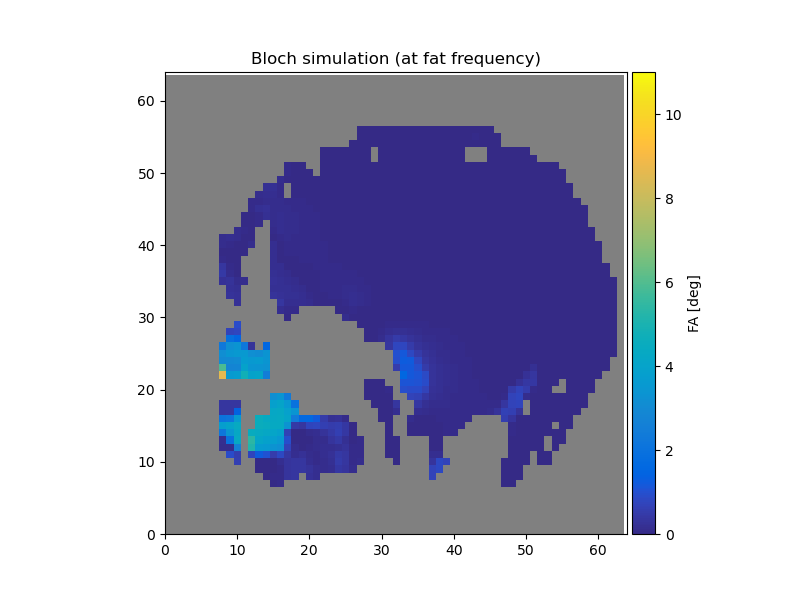

In [7]:
B0_masked = np.transpose(np.ma.masked_where(Adj['W'] == 0.0, Adj['B0']), (1,0,2))
absS = np.transpose(np.ma.masked_where(np.tile(Adj['W'],(8,1,1,1)) == 0.0, np.abs(S)), (0,2,1,3))
bl_w = np.transpose(np.ma.masked_where(Adj['W'] == 0.0, bl_water), (1,0,2))
bl_f = np.transpose(np.ma.masked_where(Adj['W'] == 0.0, bl_fat), (1,0,2))

show_results.image(B0_masked, absS, bl_w, bl_f)

## Show pulse shapes

Display RF and gradient pulse shapes for the original and binomial pulses.

Output()

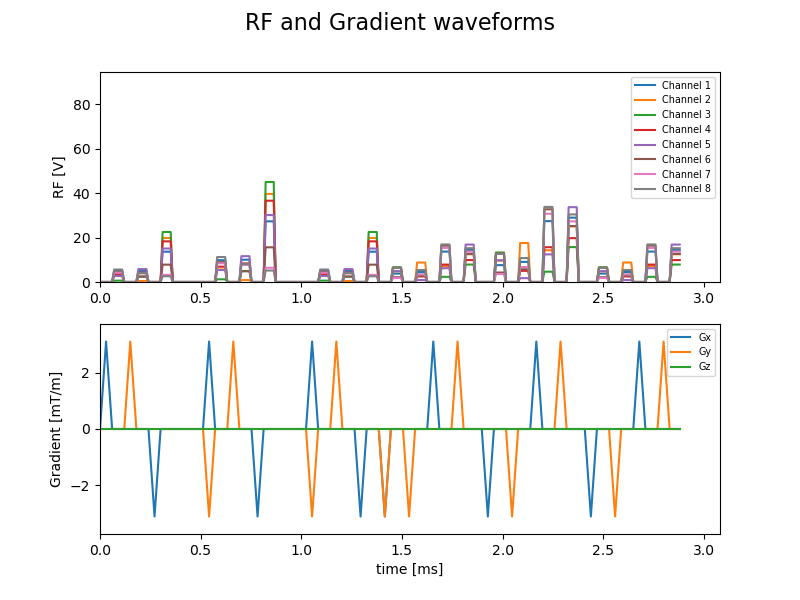

In [8]:
show_results.pulseshape(g, g_bino, RF, RF_bino, dt)